In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wbdata
import seaborn as sns
import json
from bs4 import BeautifulSoup
import requests
import pycountry
 
from scipy import stats

In [3]:
#Step 1: retrieving additional data
response = requests.get('https://stats.oecd.org/restsdmx/sdmx.ashx/GetData/GIDDB2014/ALL.AUS+AUT+BEL+CAN+CHL+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+JPN+KOR+LVA+LTU+LUX+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA+NMEC+AFG+ALB+DZA+AGO+ARG+ARM+AZE+BHR+BGD+BLR+BEN+BTN+BOL+BIH+BWA+BRA+BGR+BFA+BDI+KHM+CMR+CAF+TCD+CHN+COL+COG+COD+CRI+CIV+HRV+CUB+CYP+DOM+ECU+EGY+SLV+GNQ+ERI+ETH+FJI+MKD+GAB+GMB+GEO+GHA+GTM+GIN+GNB+HTI+HND+HKG+IND+IDN+IRN+IRQ+JAM+JOR+KAZ+KEN+PRK+KWT+KGZ+LAO+LBN+LSO+LBR+LBY+MDG+MWI+MYS+MLI+MRT+MUS+MDA+MNG+MAR+MOZ+MMR+NAM+NPL+NIC+NER+NGA+PSE+OMN+PAK+PAN+PNG+PRY+PER+PHL+QAT+ROU+RUS+RWA+SAU+SEN+SRB+SLE+SGP+SOM+ZAF+LKA+SDN+SWZ+SYR+TJK+TZA+THA+TLS+TGO+TTO+TUN+TKM+UGA+UKR+ARE+URY+UZB+VEN+VNM+YEM+ZMB+ZWE.AIC.FC_2/all?startTime=2014&endTime=2014')
data = response.content
soup = BeautifulSoup(data, "lxml")
#print(soup)

#Step 2: Lists are created to make a dataframe
list_country = [x.get_attribute_list('value')[0] for x in soup.find_all("value", attrs={ "concept" : "LOCATION"})]
list_date = [x.text for x in soup.find_all("time")]
list_variable = [x.get_attribute_list('value')[0] for x in soup.find_all("value", attrs={ "concept" : "VAR"})]
list_value = [x.get_attribute_list('value')[0] for x in soup.find_all("obsvalue", attrs={ "value" : True})]

#Step 3: ISO-two digit countrycode convertion to ISO-three digit country code
new_countrylist = [ pycountry.countries.get(alpha_3=i).alpha_2 for i in list_country ]
# new_countrylist

#Step 4: Creating dataframe
OECD_df = pd.DataFrame({'country':new_countrylist,'date':list_date,'indicator':list_variable, 'value':list_value})
# OECD_df

#Step 5: Changing column values
OECD_df['value'] = OECD_df.value.astype(float).round(6)
OECD_df['value'] = OECD_df['value'] *100
OECD_df['indicator']= 'Percentage of women married between 15-19 years of age' 
OECD_df['date'] = OECD_df.date.astype(int)
# OECD_df

In [17]:
def clean(dataset):
    #create data frame
    name = pd.DataFrame(wbdata.get_data(dataset))
    
    #clean the date
    name['country_code'] = name.country.astype(str).str.slice(8,10)
    name['country'] = name.country.astype(str).str.slice(23,-2)
    name['indicator'] = name.indicator.astype(str).str.slice(35,-2)
    name["date"] = name["date"].astype(int) 
    name["value"] = name["value"].astype(float).round(2)
            
    return name

In [4]:
def fillna(name):
    for i in name.country.unique():
        name.loc[name['country'] == i]  = name.loc[(name['country'] == i)].ffill().bfill()
    return name

In [5]:
def graph(dataframe, title_graph = '', x_label= '', y_label = ''):
    # Visualising changes over time per indicator

    fig,ax = plt.subplots(figsize=(30, 15))

    for name in dataframe["country"].unique():
        ax.plot(dataframe[dataframe.country==name].date, dataframe[dataframe.country==name].value,label=name)

    #change size and location of legend
    ax.legend(loc=(1.1, 0.2), fontsize = 'xx-large')

    #values of the x and y axis
    plt.xticks(rotation = 65, fontsize = 20)
    plt.yticks(fontsize = 20)

    #labels of the x and y axis 
    plt.title(title_graph, fontsize = 30)
    plt.xlabel(x_label, fontsize = 25)
    plt.ylabel(y_label, fontsize = 25)

In [6]:
def makeScatter(x, y, title ='', xlabel = '', ylabel = ''):
    plt.figure(figsize=(20,10))
    
    #plot the scatter with line
    sns.regplot(x,y, color = 'orchid')
    
    #labels
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.xticks(rotation = 65, fontsize = 15)
    plt.yticks(fontsize = 15)

In [7]:
def makeBarPlot(x, y, title_graph = "", xlabel = "", ylabel = ""):
    #make array from the columns of the dataframe
    array1 = x.values
    array2 = y.values
    
    # colors for the bars
    colors = ["Red", "Blue", "Yellow", "Green", "Pink", "Cyan"]
    
    # set the cells that contain missing values at zero
    array2[np.isnan(array2)] = 0
    
    # plot the bar
    plt.figure(figsize=(30,10))
    plt.bar(array1, array2, color = colors, width = 0.8, align='center')

    plt.xticks(np.arange( len(array1) ), array1, rotation = 65, fontsize = 20)
    plt.yticks(fontsize = 20)
    
    # labels
    plt.title(title_graph, fontsize = 30)
    plt.xlabel(xlabel, fontsize = 25)
    plt.ylabel(ylabel, fontsize = 25)
    
    # Get the value of the bar on top of the bar
    for (i, value) in enumerate (array2):
        plt.text(i- 0.4 , value, "%.2f" % (value) , fontsize = 20)
        

In [8]:
def getYears15(name):
    name.date = name.date.astype(int)
    years = name.loc[(name['date'] >= 2007) & (name['date'] <= 2017)]

    years_worst = years.loc[(years.country.isin(CPIA_worst15.country)),:]
    years_worst_sorted = years_worst.sort_values(by='date',ascending=True)
    
    
    return years_worst_sorted

# Child marriage

Chil marriage over the past years (2007-2017), has child marriage dropped? (marriage before 15 and marriage before 18 (data checking/ fact checking) and if this rate contineous, will goal 5.3 be reached in 2030?(extrapoleren):
    - Child marriage percentage per country over time 
        -How was it in the past
        -how is it now
        -how will it develop over time

#### Deze data laat zien hoe het er nu voor staat met het aantal child marriages

This data shows the percentage of women who were first married by the age of 15.

In [9]:
CPIA_all = clean("IQ.CPA.GNDR.XQ")
#CPIA_all = fillna(CPIA_all)

# Filter the dataset on year and on country code which are not numeric
CPIA_all_year_alpha = CPIA_all.loc[(CPIA_all['date'] == 2017) & (CPIA_all.country_code.str.isalpha())]
CPIA_OnlyCountries = CPIA_all_year_alpha[17:]

#sort the countries by 'value' (their rating) and only show the Top 15
CPIA_worst15 = CPIA_OnlyCountries.sort_values(by='value', ascending=True)[:15]

In [10]:
# married15_all = pd.DataFrame(wbdata.get_data("SP.M15.2024.FE.ZS"))
# married15_all['country'] = married15_all.country.astype(str).str.slice(23,-2)
# married15_all['indicator'] = married15_all.indicator.astype(str).str.slice(35,-2)
# married15_all['value'] = married15_all.value.astype(float).round(1)


# #find rows where the value is greater than 0
# married15_all = married15_all.loc[(married15_all["value"] >= 0)]

# #find the rows with the most recent data
# married15_now = married15_all.sort_values("date", ascending = False).drop_duplicates(["country"])
# married15_now["date"] = married15_now.date.astype(str)

married15_all = clean("SP.M15.2024.FE.ZS")
married15_all = fillna(married15_all)

In [11]:
married15_all = pd.merge(married15_all, OECD_df, how="left", left_on = ['country_code','date', 'value'],  
                         right_on =['country', 'date', 'value'] )
married15_all = married15_all.rename(index = str, columns = {'country': 'country_false', 'country_x': "country", })
married15_all.head()

,country,date,decimal,indicator_x,value,country_code,country_y,indicator_y
0,Arab World,2017,2,: 'Women who were first married by age 15 (% o...,NaN,1A,NaN,NaN
1,Arab World,2016,2,: 'Women who were first married by age 15 (% o...,NaN,1A,NaN,NaN
2,Arab World,2015,2,: 'Women who were first married by age 15 (% o...,NaN,1A,NaN,NaN
3,Arab World,2014,2,: 'Women who were first married by age 15 (% o...,NaN,1A,NaN,NaN
4,Arab World,2013,2,: 'Women who were first married by age 15 (% o...,NaN,1A,NaN,NaN


## Correlatie

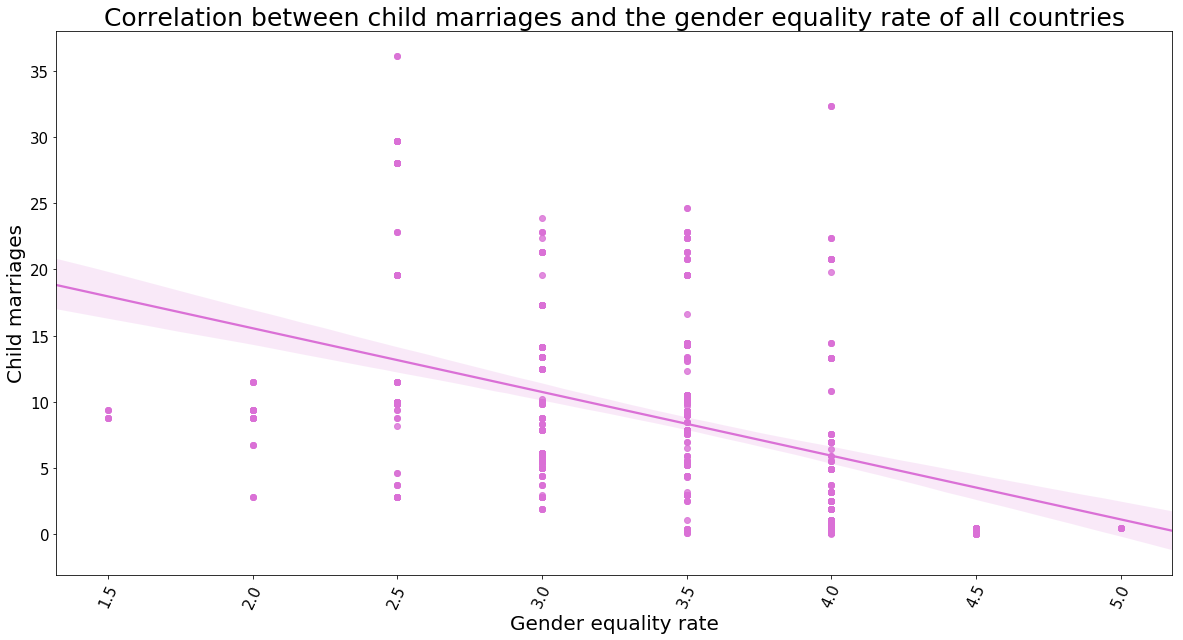

In [12]:
makeScatter(CPIA_all['value'], married15_all['value'], 
            "Correlation between child marriages and the gender equality rate of all countries",
            'Gender equality rate', "Child marriages")

Because we only look at the top 15 countries with the lowest equality rate. A new dataframe is made only containing the countries with this low equality rate compared.

In [13]:
married15_worst15 = pd.merge( CPIA_worst15, married15_all, how = "left", left_on = ["country", 'date'], 
                             right_on = ["country", 'date'])
married15_worst15.head()

,country,date,decimal_x,indicator,value_x,country_code_x,decimal_y,indicator_x,value_y,country_code_y,country_y,indicator_y
0,Afghanistan,2017,1,CPIA gender equality rating (1=low to 6=high),1.5,AF,2,: 'Women who were first married by age 15 (% o...,8.8,AF,NaN,NaN
1,"Yemen, Rep.",2017,1,CPIA gender equality rating (1=low to 6=high),1.5,YE,2,: 'Women who were first married by age 15 (% o...,9.4,YE,NaN,NaN
2,Somalia,2017,1,CPIA gender equality rating (1=low to 6=high),2.0,SO,2,: 'Women who were first married by age 15 (% o...,NaN,SO,NaN,NaN
3,Guinea-Bissau,2017,1,CPIA gender equality rating (1=low to 6=high),2.0,GW,2,: 'Women who were first married by age 15 (% o...,NaN,GW,NaN,NaN
4,South Sudan,2017,1,CPIA gender equality rating (1=low to 6=high),2.0,SS,2,: 'Women who were first married by age 15 (% o...,NaN,SS,NaN,NaN


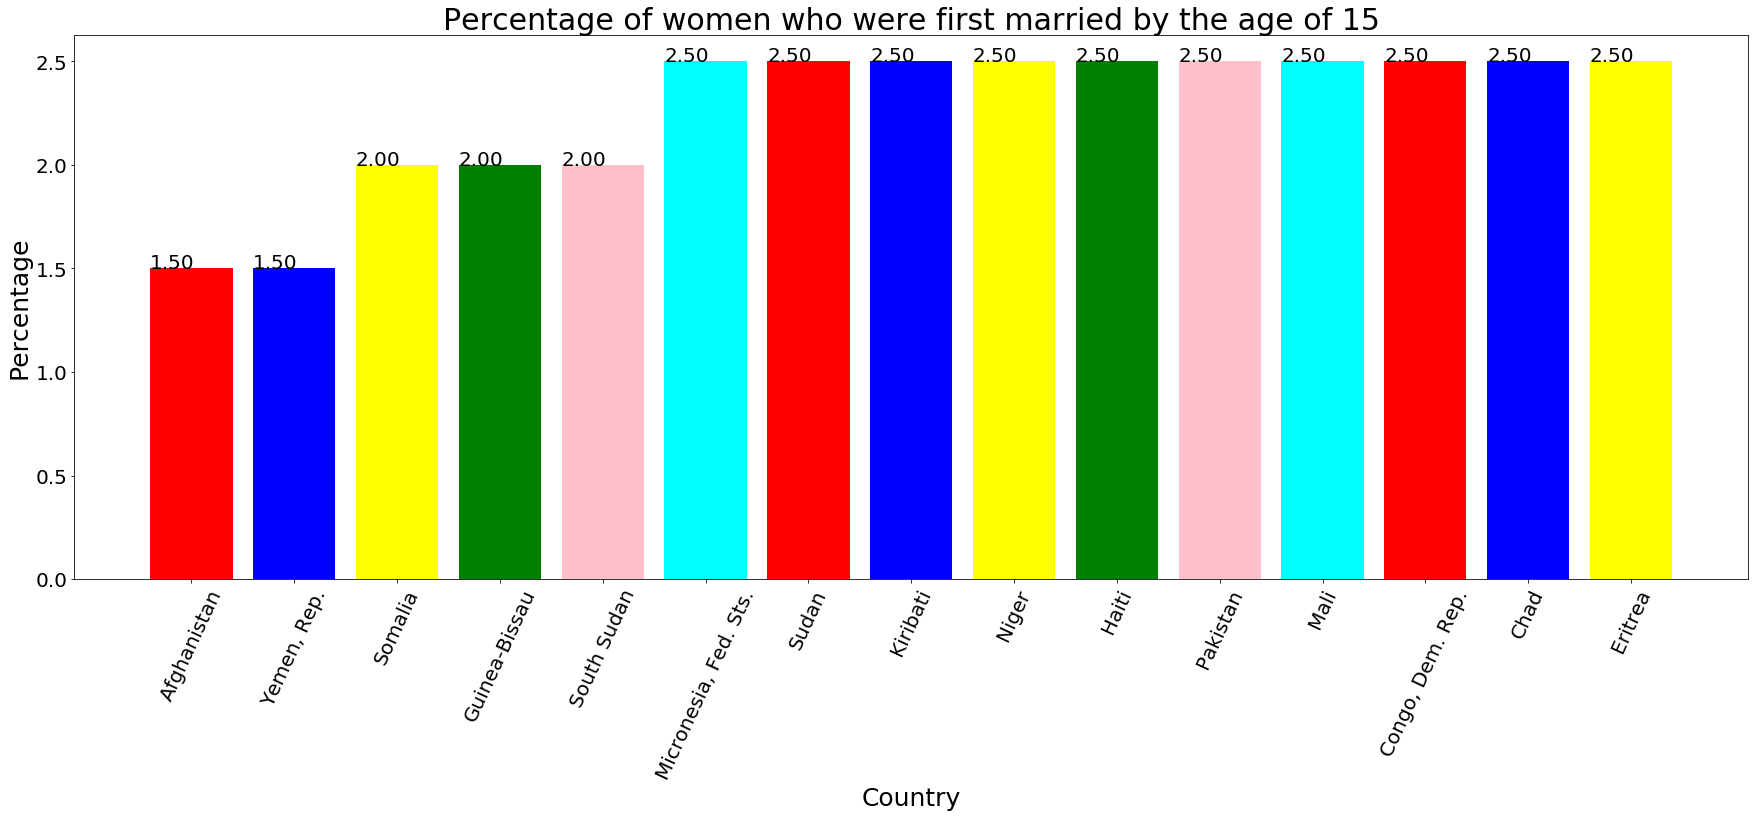

In [14]:
# bar plot van de 15 landen. 

# jaartal van data van married 15 moet nog in de bar plot, aangezien geen data beschikbaar is van 2017. 
# Hiervan moeten we misschien ook nog andere dataset gebruiken, zodat deze aangevuld kan worden. 
# Misschien dat we dan wel recentere data kunnen gebruiken

#married15_worst15.plot(kind="bar", x = "country", y = "value_y", legend = False)
    
# array maken van de twee kolommen die nuttig zijn 
# country_married_worst15 = married15_worst15.country.values
# value_married_worst15 = married15_worst15.value_y.values

# colors = ["Red", "Blue", "Yellow", "Green", "Pink", "Cyan"]

# value_married_worst15[np.isnan(value_married_worst15)] = 0

# plt.figure(figsize=(30, 10))
# plt.bar(country_married_worst15, value_married_worst15, color = colors, width = 0.8, align='center')

# #tekst onder x-as is gek!
# plt.xticks(rotation = 65, fontsize = 20)
# plt.yticks(fontsize = 20)

# plt.title("Percentage of women who were first married by the age of 15" , fontsize = 30)
# plt.xlabel("Country" , fontsize = 25)
# plt.ylabel("Percentage" , fontsize = 25)


# # De waarde van het land bovenop bar
# for (i, value) in enumerate (value_married_worst15):
#     plt.text(i- 0.2 , value + 0.5 , "%.2f" % (value) , fontsize = 20)

makeBarPlot(married15_worst15['country'], married15_worst15['value_x'], 
            title_graph = "Percentage of women who were first married by the age of 15", 
            xlabel = "Country", ylabel = "Percentage")

# visualiseren dat de data van married 15 van sommige landen niet recent is. 


#### Data van vroeger tot nu

In [15]:
# married15_all gebruiken om te kunnen laten zien hoe het aantal kindhuwelijken over de jaren heen is veranderd

# married15_years = married15_all.loc[((married15_all["country"].isin(CPIA_worst15["country"]))),:].sort_values(by = "date", ascending = True)

# married15_years["date"] = married15_years["date"].astype(int)

# #drop rows with date < 2000 
# married15_lowerYears = married15_years[married15_years['date'] < 2000]
# married15_years = married15_years.drop(married15_lowerYears.index, axis = 0)

# married15_years.head()


married15_years = getYears15(married15_all)


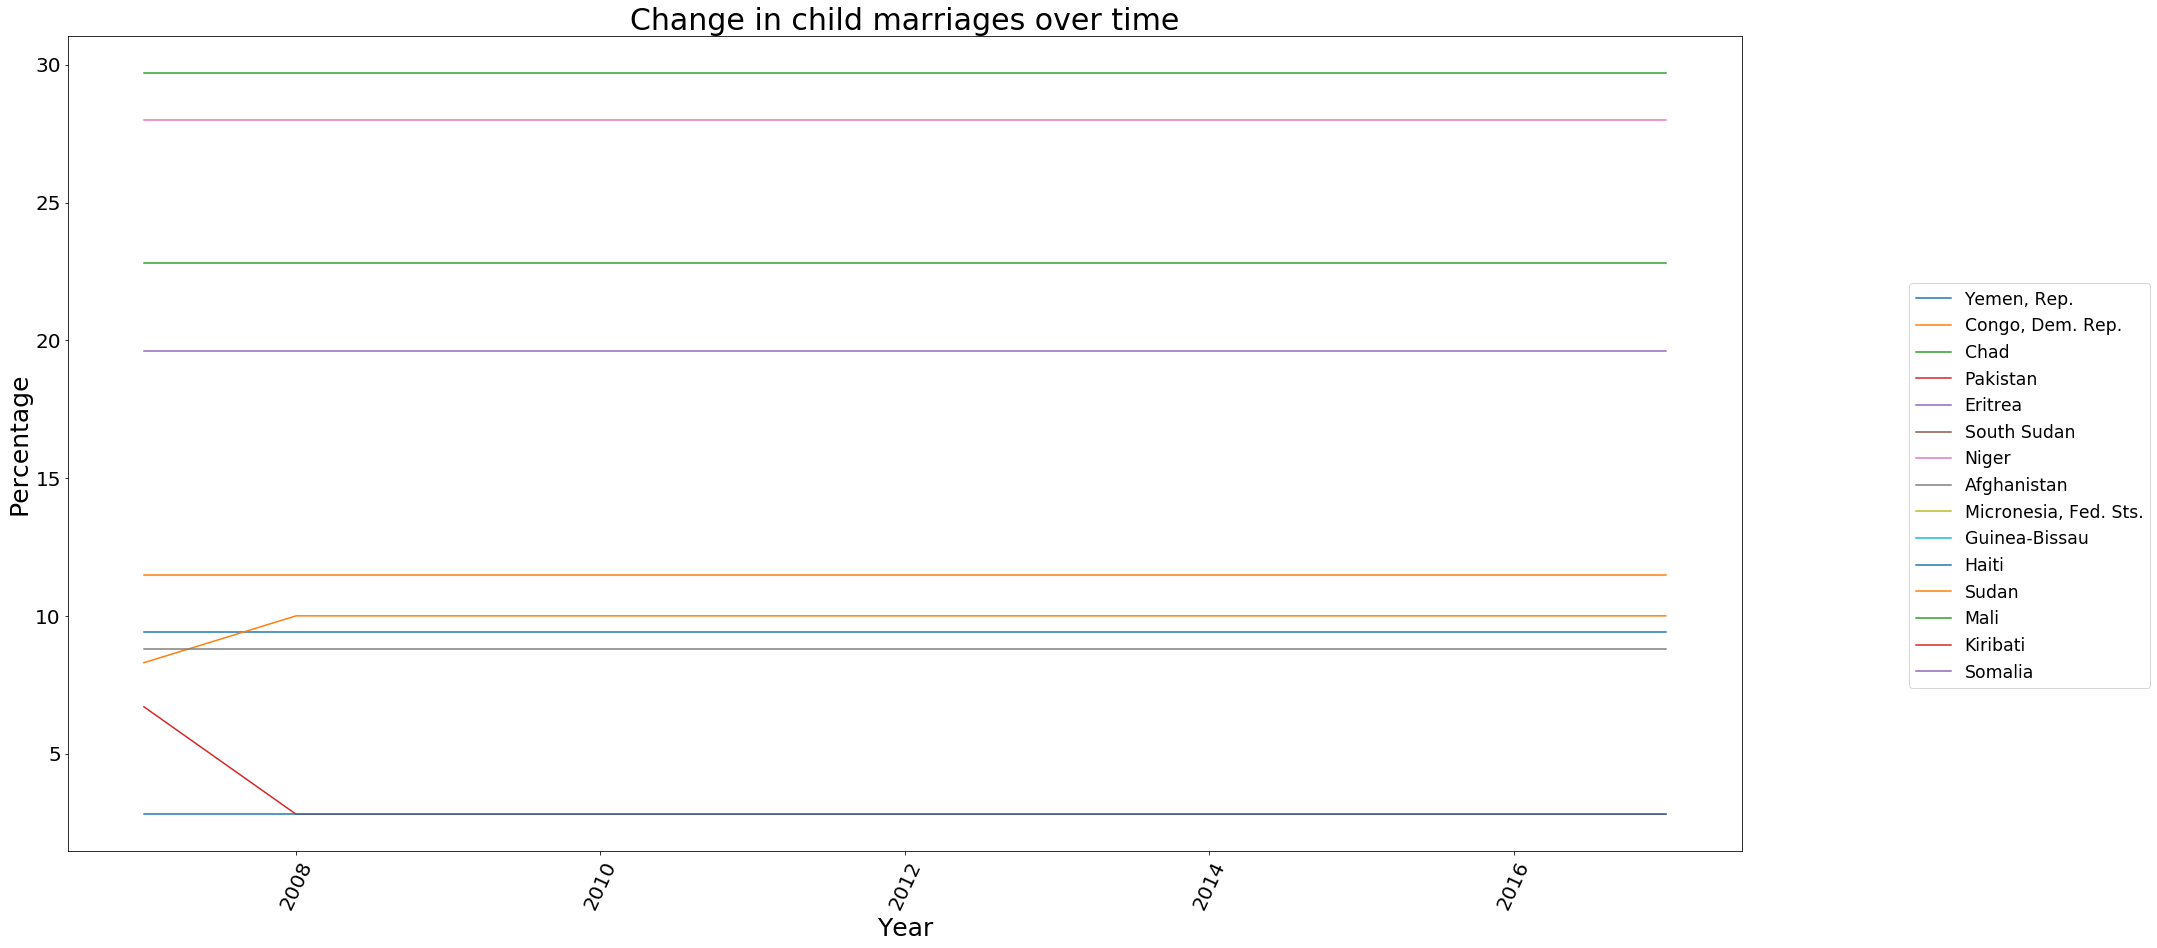

In [16]:
# # visualiseren van verandering per land

# fig1,ax1 = plt.subplots(figsize=(20, 10))

# for name in married15_years["country"].unique():
#     ax1.plot(married15_years[married15_years.country==name].date,married15_years[married15_years.country==name].value,label=name)

# #change size and location of legend
# ax1.legend(loc=(1.1, 0.2), fontsize = 'x-large')

# #tekst op x en y-as
# plt.xticks(rotation = 65, fontsize = 20)
# plt.yticks(fontsize = 20)

# #labels
# plt.title("Change in child marriages over time", fontsize = 30)
# plt.xlabel("Year", fontsize = 25)
# plt.ylabel("Percentage", fontsize = 25)

# # stapgrootte x-as

graph(married15_years, "Change in child marriages over time",'Year', "Percentage")
